In [2]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

%matplotlib inline
import matplotlib.pyplot as plt # библиотека визуализации
import seaborn as sns
# sns.set_style('whitegrid')
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(10, 8)})

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

import pandas as pd
import numpy as np
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
from sklearn.model_selection import train_test_split
import Handlers as hd

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
TARGET_FEATURE = 'reviewer_score'
TEST_SIZE = 0.2

In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > requirements.txt

In [6]:
# Подгрузим наши данные из соревнования
df_train = pd.read_csv('data/hotels_train.csv.zip') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv.zip') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv.zip') # самбмишн

### Первичный анализ тренировочного датасета

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [8]:
df_train

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.40,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.00,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.51,-0.14
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.30,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.30,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.52,-0.12
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.90,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.50,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.85,2.33
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.50,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.00,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.89,2.39
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.50,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.60,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.39,4.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.00,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.80,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.49,-0.19
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.40,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,9.20,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.19,16.40
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.80,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.30,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.52,-0.13
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.10,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.20,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.52,-0.16


In [9]:
# negative_review и review_total_negative_word_counts имеют по 24% одинаковых значений, интересно
hd.get_low_inform_features_list(df_train, level=0)

hotel_address: 0.93% одинаковых значений
additional_number_of_scoring: 0.93% одинаковых значений
review_date: 0.49% одинаковых значений
average_score: 8.0% одинаковых значений
hotel_name: 0.93% одинаковых значений
reviewer_nationality: 47.58% одинаковых значений
negative_review: 24.79% одинаковых значений
review_total_negative_word_counts: 24.79% одинаковых значений
total_number_of_reviews: 0.93% одинаковых значений
positive_review: 6.95% одинаковых значений
review_total_positive_word_counts: 6.95% одинаковых значений
total_number_of_reviews_reviewer_has_given: 29.98% одинаковых значений
reviewer_score: 22.44% одинаковых значений
tags: 1.0% одинаковых значений
days_since_review: 0.49% одинаковых значений
lat: 0.93% одинаковых значений
lng: 0.93% одинаковых значений


['hotel_address',
 'additional_number_of_scoring',
 'review_date',
 'average_score',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'positive_review',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'tags',
 'days_since_review',
 'lat',
 'lng']

In [10]:
# Совмем мало пропусков
hd.get_columns_isnull_info_df(df_train)

lng   0.63
lat   0.63
dtype: float64

In [11]:
# По повторам в negative_review стало понятно, это короткие однотипные комментарии
hd.get_top_unique_values(df_train)

,Column Name,Count Unique,% Unique,Top Value,Top Value Count,Top Value %
0,hotel_address,1493,0.39,163 Marsh Wall Docklands Tower Hamlets London ...,3587,0.93
1,additional_number_of_scoring,480,0.12,2682,3587,0.93
2,review_date,731,0.19,8/2/2017,1911,0.49
3,average_score,34,0.01,8.40,30929,8.00
4,hotel_name,1492,0.39,Britannia International Hotel Canary Wharf,3587,0.93
5,reviewer_nationality,225,0.06,United Kingdom,184033,47.58
6,negative_review,248828,64.33,No Negative,95907,24.79
7,review_total_negative_word_counts,402,0.10,0,95907,24.79
8,total_number_of_reviews,1142,0.30,9086,3587,0.93
9,positive_review,311737,80.59,No Positive,26885,6.95


### Первичный анализ тестового датасета

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [13]:
df_test

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.10,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.53,9.17
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.60,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.39,4.83
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.30,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.39,2.16
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.10,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.48,9.20
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.10,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.37,4.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128930,Viale Monza 132 Distretto Viale Monza 20127 Mi...,53,2/3/2016,8.10,Best Western Antares Hotel Concorde,Greece,No Negative,0,984,nice breakfast,4,14,"[' Business trip ', ' Couple ', ' Double Room ...",547 day,45.50,9.22
128931,Duc De Medinaceli 8 Ciutat Vella 08002 Barcelo...,46,6/18/2016,7.80,Medinaceli,United States of America,No Negative,0,523,Beautiful historic hotel in great location in...,24,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",411 day,41.38,2.18
128932,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...,260,7/6/2017,8.00,Suite Hotel 900 m zur Oper,New Zealand,No coffee in complimentary coffee in the room...,31,3461,The size of the room the courtyard and the lo...,23,1,"[' Business trip ', ' Solo traveler ', ' Singl...",28 days,48.19,16.37
128933,Corso Concordia 1 Milan City Center 20129 Mila...,159,12/26/2015,9.00,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel well loca...,20,7,"[' Leisure trip ', ' Solo traveler ', ' Execut...",586 day,45.47,9.21


In [14]:
# Смотрю на низкоинформативные признаки
hd.get_low_inform_features_list(df_test)

[]

In [15]:
# Совмем мало пропусков
hd.get_columns_isnull_info_df(df_test)

lng   0.64
lat   0.64
dtype: float64

In [16]:
# По повторам в negative_review стало понятно, это короткие однотипные комментарии
hd.get_top_unique_values(df_test)

,Column Name,Count Unique,% Unique,Top Value,Top Value Count,Top Value %
0,hotel_address,1493,1.16,163 Marsh Wall Docklands Tower Hamlets London ...,1202,0.93
1,additional_number_of_scoring,480,0.37,2682,1202,0.93
2,review_date,731,0.57,8/2/2017,674,0.52
3,average_score,34,0.03,8.40,10293,7.98
4,hotel_name,1492,1.16,Britannia International Hotel Canary Wharf,1202,0.93
5,reviewer_nationality,202,0.16,United Kingdom,61213,47.48
6,negative_review,84673,65.67,No Negative,31983,24.81
7,review_total_negative_word_counts,369,0.29,0,31983,24.81
8,total_number_of_reviews,1142,0.89,9086,1202,0.93
9,positive_review,106112,82.30,No Positive,9061,7.03


### Файл сабмишшена

In [17]:
# Нужно своими значениями заменить столбцец reviewer_score
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [18]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [19]:
df_train

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.40,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.00,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.51,-0.14
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.30,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.30,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.52,-0.12
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.90,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.50,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.85,2.33
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.50,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.00,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.89,2.39
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.50,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.60,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.39,4.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.00,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.80,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.49,-0.19
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.40,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,9.20,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.19,16.40
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.80,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.30,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.52,-0.13
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.10,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.20,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.52,-0.16


In [20]:
# Объединяю датафреймы для удобной обработки признаков
df_full = hd.merge_train_and_test_df(df_train, df_test, TARGET_FEATURE)

In [21]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515738 non-null  object  
 1   additional_number_of_scoring                515738 non-null  int64   
 2   review_date                                 515738 non-null  object  
 3   average_score                               515738 non-null  float64 
 4   hotel_name                                  515738 non-null  object  
 5   reviewer_nationality                        515738 non-null  object  
 6   negative_review                             515738 non-null  object  
 7   review_total_negative_word_counts           515738 non-null  int64   
 8   total_number_of_reviews                     515738 non-null  int64   
 9   positive_review                             515738 non-null

### Поиск дубликатов

In [22]:
df_full_dup = df_full[df_full.duplicated()]
df_full_dup

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,reviewer_score,dataset
21413,9 Rue Sainte Beuve 6th arr 75006 Paris France,22,9/27/2015,8.90,Hotel Le Sainte Beuve,Costa Rica,No Negative,0,143,Ir s a lovely boutique hotel full of Parisian...,53,4,"[' Leisure trip ', ' Family with older childre...",676 day,48.84,2.33,10.00,train
53110,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,9/25/2016,9.00,H tel Baume,Lebanon,nothing at all,4,253,bed was great staff are wonderful location ve...,10,1,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",312 day,48.85,2.34,10.00,train
54461,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,8/2/2016,7.90,H tel Concorde Montparnasse,Israel,The room to far from elevator,7,2515,Staff very nice and helpful Breakfast was per...,17,2,"[' Couple ', ' Classic Twin Room ', ' Stayed 3...",366 day,48.84,2.32,8.30,train
56542,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,7/2/2017,9.00,H tel Baume,Romania,Breakfast was a huge joke It was the worst po...,19,253,Room was great nice and spacious appartment f...,14,7,"[' Leisure trip ', ' Family with young childre...",32 days,48.85,2.34,7.90,train
65789,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,8/11/2015,9.00,H tel Baume,United Kingdom,No Negative,0,253,Friendly reception staff clean bathroom and l...,11,1,"[' Leisure trip ', ' Couple ', ' Superior Doub...",723 day,48.85,2.34,10.00,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499212,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,5/23/2016,7.90,H tel Concorde Montparnasse,United States of America,Nothing I will stay at this hotel again on my...,24,2515,The staff was very helpful and the property w...,21,8,"[' Leisure trip ', ' Family with older childre...",437 day,48.84,2.32,0.00,test
506924,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,2/1/2016,7.90,H tel Concorde Montparnasse,Malta,beautiful wiew,3,2515,cleanness staff very friendly very helpful,7,2,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",549 day,48.84,2.32,0.00,test
509781,167 rue de Rome 17th arr 75017 Paris France,11,12/12/2016,6.80,Villa Eugenie,Canada,Listed above,3,165,It was a terrible stat unfriendly staff very ...,13,1,"[' Business trip ', ' Solo traveler ', ' Stand...",234 day,48.89,2.31,0.00,test
512237,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,9/22/2015,7.90,H tel Concorde Montparnasse,Germany,Breakfast is pretty expensive however good,8,2515,Very good location good connections with Metr...,24,5,"[' Leisure trip ', ' Group ', ' Classic Twin R...",681 day,48.84,2.32,0.00,test


In [23]:
# Количество дубликатов в тестовом и трейн датасете
df_full_dup.groupby('dataset').agg({'hotel_name': 'count'})

,hotel_name
dataset,
test,29
train,307


In [1]:
df_full.duplicated().mean()

NameError: name 'df_full' is not defined

### Просто удалить дубликаты не могу
### Создаю бинарный признак, о том что запись дубликат

In [23]:

df_full['duplicate'] = df_full.duplicated()

In [24]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515738 non-null  object  
 1   additional_number_of_scoring                515738 non-null  int64   
 2   review_date                                 515738 non-null  object  
 3   average_score                               515738 non-null  float64 
 4   hotel_name                                  515738 non-null  object  
 5   reviewer_nationality                        515738 non-null  object  
 6   negative_review                             515738 non-null  object  
 7   review_total_negative_word_counts           515738 non-null  int64   
 8   total_number_of_reviews                     515738 non-null  int64   
 9   positive_review                             515738 non-null

### Анализ признаков

In [25]:
# Если количество уникальных признаков < 150 то можно жумать о переводе признака в категориальный
hd.get_top_unique_values(df_full)

,Column Name,Count Unique,% Unique,Top Value,Top Value Count,Top Value %
0,hotel_address,1493,0.29,163 Marsh Wall Docklands Tower Hamlets London ...,4789,0.93
1,additional_number_of_scoring,480,0.09,2682,4789,0.93
2,review_date,731,0.14,8/2/2017,2585,0.50
3,average_score,34,0.01,8.40,41222,7.99
4,hotel_name,1492,0.29,Britannia International Hotel Canary Wharf,4789,0.93
5,reviewer_nationality,227,0.04,United Kingdom,245246,47.55
6,negative_review,330011,63.99,No Negative,127890,24.80
7,review_total_negative_word_counts,402,0.08,0,127890,24.80
8,total_number_of_reviews,1142,0.22,9086,4789,0.93
9,positive_review,412601,80.00,No Positive,35946,6.97


In [39]:
# 
hd.get_low_inform_features_list(df_full)

duplicate: 99.93% одинаковых значений


['duplicate']

# average_score это порядковый категориальный признак

In [27]:
# Значения в промеждутке от 5 до 10
df_full['average_score'].describe()

count   515738.00
mean         8.40
std          0.55
min          5.20
25%          8.10
50%          8.40
75%          8.80
max          9.80
Name: average_score, dtype: float64

NameError: name 'fig' is not defined

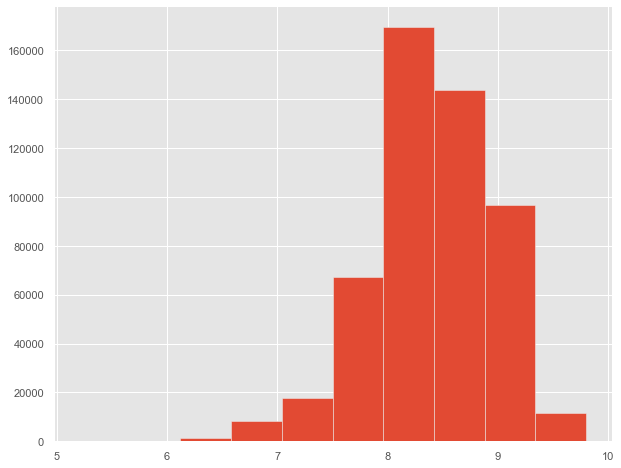

In [30]:
ax = df_full['average_score'].hist()
fig.title('fgbgf')


### average_score, варианты разбиения на категории

In [103]:
# df_full['average_score_cat'] = pd.cut(df_full['average_score'], bins=[5, 6, 7, 8, 9, 10], include_lowest=True)
# df_full['average_score_cat'] = pd.cut(df_full['average_score'], bins=list(np.arange(5, 10.5, 0.5)), include_lowest=True) # C шагом 0.5
# df_full['average_score_cat'] = pd.qcut(df_full['average_score'], q=5) # 5 бинов с примерно одинаковым распределением внутри

df_full['average_score_cat'] = pd.cut(df_full['average_score'], bins=[5, 7, 7.5, 8, 8.5, 9, 9.5, 10], labels=['5-6', '7', '7+', '8', '8+', '9', '9+'], include_lowest=True)

In [104]:
# df_full['average_score_cat'].value_counts(True) * 100

In [105]:
# df_full['average_score_cat'].cat.categories

In [108]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515738 non-null  object  
 1   additional_number_of_scoring                515738 non-null  int64   
 2   review_date                                 515738 non-null  object  
 3   average_score                               515738 non-null  float64 
 4   hotel_name                                  515738 non-null  object  
 5   reviewer_nationality                        515738 non-null  object  
 6   negative_review                             515738 non-null  object  
 7   review_total_negative_word_counts           515738 non-null  int64   
 8   total_number_of_reviews                     515738 non-null  int64   
 9   positive_review                             515738 non-null

### lat and lng

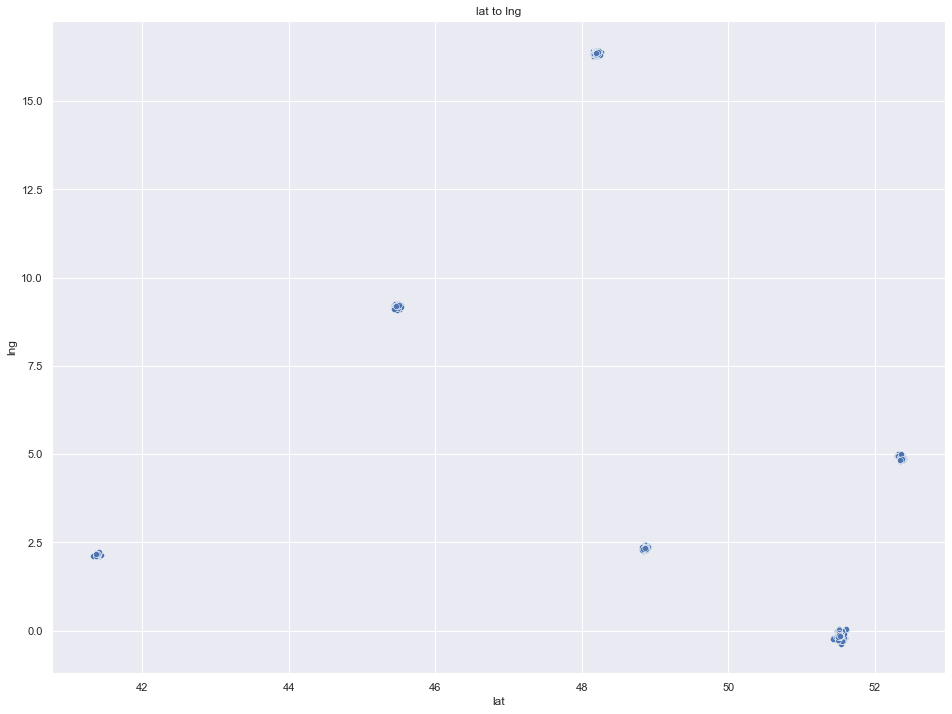

In [109]:
# Диаграмма рассеяния отлично показывает скопления координат. Фактически имеем 6 локаций где находятся отели
fig = plt.figure(figsize=(16, 12))
ax = sns.scatterplot(x=df_full['lat'], y=df_full['lng'])
ax.set_title('lat to lng')
fig.show()

In [114]:
# Заполнять пропуски по простому, по медиане, это будет правое нижнее скопление
vals = {'lat': df_full['lat'].median(),
        'lng': df_full['lng'].median()}
df_full.fillna(value=vals, inplace=True)

### hotel_address

In [119]:
# Визуальный анализ адресов показывает что в самом конце идет название страны, перед жтим город.
# Название страны из одного слова, кроме случаев United Kingdom
# df_full['hotel_address'].to_list()

In [120]:
def country_feature(hotel_address):
    hotel_address = str(hotel_address)
    
    address_lst = hotel_address.split()
    
    last_word = address_lst[-1]
    
    if last_word == 'Kingdom':
        return 'United Kingdom'
    
    return last_word

In [122]:
df_full['country'] = df_full['hotel_address'].apply(country_feature)

In [124]:
# Получается всего 6 стран, это категориальный признак
df_full['country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

In [125]:
df_full['country'] = df_full['country'].astype('category')

### Получение города из адреса

In [145]:
def city_feature(hotel_address):
    hotel_address = str(hotel_address)
    
    address_lst = hotel_address.split()
    
    last_word = address_lst[-1]
    
    if last_word == 'Kingdom':
        return address_lst[-5]
    
    return address_lst[-2]

In [146]:
df_full['city'] = df_full['hotel_address'].apply(city_feature)

In [147]:
# Всего 6 городов, как и стран. Получается по городу в стране.
# Два эти признака кажется полностью дублируют друг друга, но пока оставляю.
df_full['city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

In [148]:
# Город это тоже категориальный номинальный признак
df_full['city'] = df_full['city'].astype('category')

In [150]:
# Из адреса больше ничего выделать не буду, удаляю признак
df_full.drop('hotel_address', axis=1, inplace=True)

### Страна и город
Могу получить дополнительный признак является ли город столицей

In [152]:
def is_capital_feature(city):
    # Складываю в список столицы
    # Столица Италии - Рим, а не Милан
    # Столица Испании - Мадрид, а не Барселона
    capitals = ['London', 'Paris', 'Amsterdam', 'Vienna']
    
    if city in capitals:
        return True
    
    return False

In [153]:
df_full['is_capital'] = df_full['city'].apply(is_capital_feature)

Признак города можно удалить.
Либо взять информацию по населению страны и города и выделить признак доля населения в % от страны приходящаяся на город.

In [154]:
df_full

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,days_since_review,lat,lng,reviewer_score,dataset,duplicate,average_score_cat,country,city,is_capital
0,581,2/19/2016,8.40,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,...,531 day,51.51,-0.14,10.00,train,False,8,United Kingdom,London,True
1,299,1/12/2017,8.30,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,...,203 day,51.52,-0.12,6.30,train,False,8,United Kingdom,London,True
2,32,10/18/2016,8.90,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,...,289 day,48.85,2.33,7.50,train,False,8+,France,Paris,True
3,34,9/22/2015,7.50,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,...,681 day,48.89,2.39,10.00,train,False,7,France,Paris,True
4,914,3/5/2016,8.50,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,...,516 day,52.39,4.85,9.60,train,False,8,Netherlands,Amsterdam,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,53,2/3/2016,8.10,Best Western Antares Hotel Concorde,Greece,No Negative,0,984,nice breakfast,4,...,547 day,45.50,9.22,0.00,test,False,8,Italy,Milan,False
515734,46,6/18/2016,7.80,Medinaceli,United States of America,No Negative,0,523,Beautiful historic hotel in great location in...,24,...,411 day,41.38,2.18,0.00,test,False,7+,Spain,Barcelona,False
515735,260,7/6/2017,8.00,Suite Hotel 900 m zur Oper,New Zealand,No coffee in complimentary coffee in the room...,31,3461,The size of the room the courtyard and the lo...,23,...,28 days,48.19,16.37,0.00,test,False,7+,Austria,Vienna,True
515736,159,12/26/2015,9.00,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel well loca...,20,...,586 day,45.47,9.21,0.00,test,False,8+,Italy,Milan,False


### days_since_review

In [ ]:
df_full['days_since_review'].describe()

count     515738
unique       731
top       1 days
freq        2585
Name: days_since_review, dtype: object

In [ ]:
def reformat_days_since_review(days_since_review):
    days_str = str(days_since_review)
    
    days = days_str.split()[0]
    
    return int(days)

In [ ]:
df_full['days_since_review'] = df_full['days_since_review'].apply(reformat_days_since_review)

In [ ]:
df_full['days_since_review'].describe()

count   515738.00
mean       354.44
std        208.93
min          0.00
25%        175.00
50%        353.00
75%        527.00
max        730.00
Name: days_since_review, dtype: float64

<AxesSubplot:>

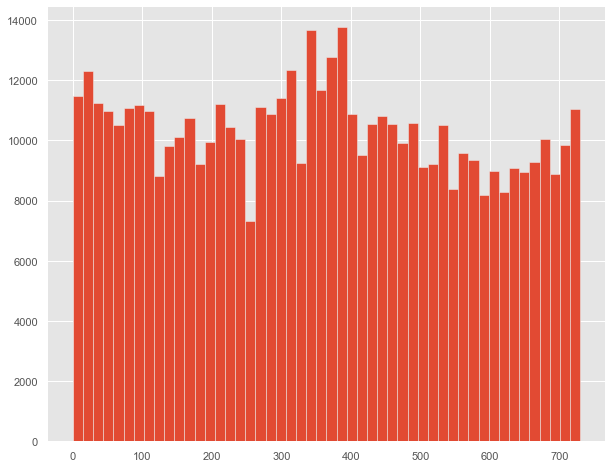

In [ ]:
df_full['days_since_review'].hist(bins=50)

<AxesSubplot:>

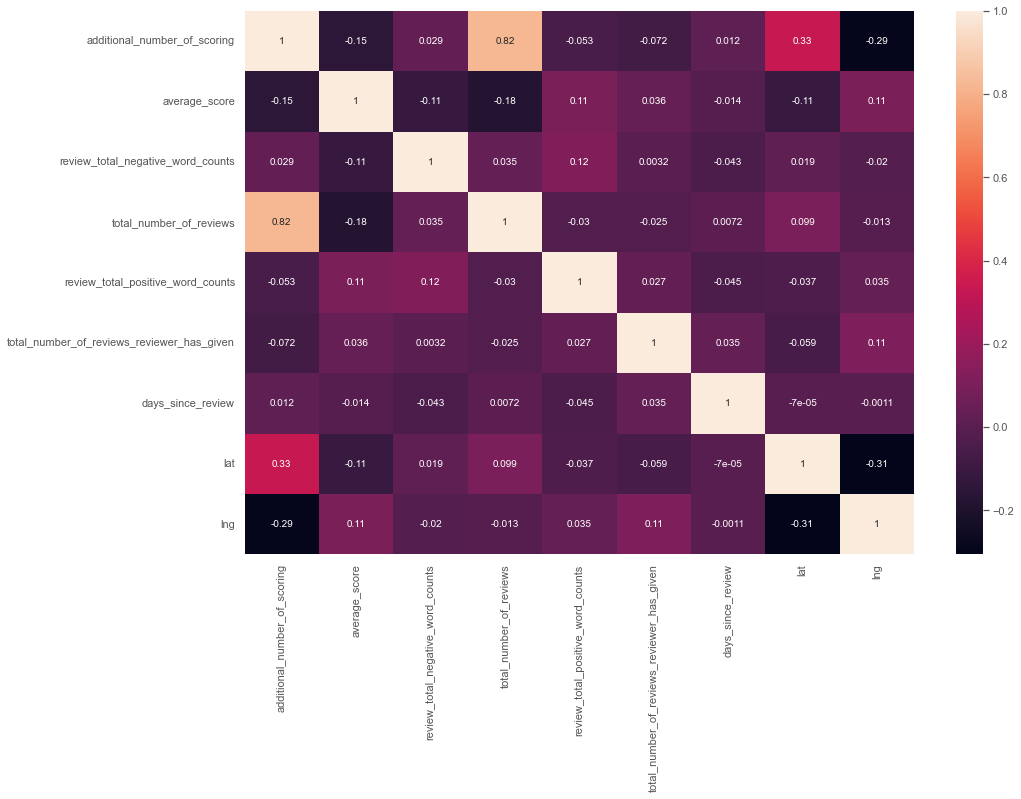

In [ ]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(df_full.drop(['dataset', 'duplicate', 'reviewer_score'], axis=1).corr(), annot=True)

In [ ]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in df_full.columns if df_full[s].dtypes == 'object']
df_full.drop(object_columns, axis = 1, inplace=True)
print('Drop columns:', object_columns)

Drop columns: ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags']


In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 12 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                515738 non-null  int64   
 1   average_score                               515738 non-null  float64 
 2   review_total_negative_word_counts           515738 non-null  int64   
 3   total_number_of_reviews                     515738 non-null  int64   
 4   review_total_positive_word_counts           515738 non-null  int64   
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64   
 6   days_since_review                           515738 non-null  int64   
 7   lat                                         515738 non-null  float64 
 8   lng                                         515738 non-null  float64 
 9   reviewer_score                              515738 non-null

### Кодирование признаков

In [ ]:
cols_to_code = ['duplicate']

In [ ]:
df_full = pd.get_dummies(df_full, columns=cols_to_code, drop_first=True)

### Разделение датасета

In [ ]:
# Обработанный датасет делим назад на треин и тест части
train_data = df_full.query('dataset == "train"').drop(['dataset'], axis=1)
test_data = df_full.query('dataset == "test"').drop(['dataset'], axis=1)


# Из трейна выделяем X и y
y = train_data[TARGET_FEATURE].values
X = train_data.drop([TARGET_FEATURE], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 11), (386803, 11), (386803, 10), (290102, 10), (96701, 10))

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
%%time
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s


CPU times: total: 4min 44s
Wall time: 26.9 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.8s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [ ]:
%%time
# Используем обученную модель для предсказания рейтинга отеля в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s


CPU times: total: 11.4 s
Wall time: 1.2 s


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.1s finished


In [ ]:
# Сравниваем реальное (y_test) с предсказанными значениями (y_pred) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13799890137462026


<AxesSubplot:>

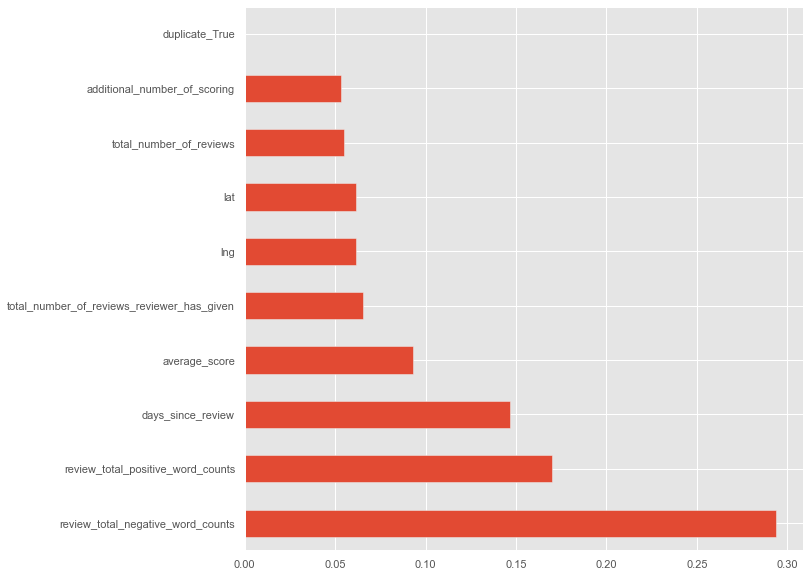

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
test_data

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,duplicate_True
386803,904,8.10,52,16670,62,1,13,45.53,9.17,0.00,0
386804,612,8.60,10,5018,0,7,234,52.39,4.83,0.00,0
386805,46,8.30,3,351,5,15,616,41.39,2.16,0.00,0
386806,241,9.10,0,1543,27,9,656,45.48,9.20,0.00,0
386807,834,9.10,0,4687,7,2,444,52.37,4.89,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...
515733,53,8.10,0,984,4,14,547,45.50,9.22,0.00,0
515734,46,7.80,0,523,24,1,411,41.38,2.18,0.00,0
515735,260,8.00,31,3461,23,1,28,48.19,16.37,0.00,0
515736,159,9.00,0,1053,20,7,586,45.47,9.21,0.00,0


In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [ ]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.4s finished


In [ ]:
predict_submission

array([8.606, 7.716, 8.252, ..., 8.113, 9.742, 7.058])

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
sample_submission

,reviewer_score,id
0,8.61,488440
1,7.72,274649
2,8.25,374688
3,9.50,404352
4,9.82,451596
...,...,...
128930,8.77,495812
128931,8.79,315577
128932,8.11,511968
128933,9.74,303386
